# Train Scikit-Learn `is_contract?` Classifier


*Version: 2022-04-19*

---

**Imports**

In [1]:
# standard library
from pathlib import Path
from typing import Final, List, Set

# third-party libraries
import cloudpickle
import matplotlib.pyplot
from numpy import ndarray
from psutil import Process
from gensim.models import Doc2Vec

# LexNLP
from lexnlp.ml.normalizers import Normalizer
from lexnlp.ml.sklearn_transformers import (
    parallel_estimator,
    TransformerVectorizer,
    TransformerPreprocessor,
)
from lexnlp.ml.vectorizers import VectorizerDoc2Vec, VectorizerKeywordSearch
from lexnlp.extract.en.contracts.predictors import ProbabilityPredictorIsContract
from lexnlp.extract.en.amounts import get_amount_annotations
from lexnlp.extract.en.dates import get_date_annotations
from lexnlp.extract.en.percents import get_percent_annotations
from lexnlp.extract.en.ratios import get_ratio_annotations

# Scikit-Learn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

---

## Constants

In [2]:
# directory paths
PATH_PREPROCESSED: Final[Path] = Path('./preprocessed/')

# Doc2Vec model
PATH_DOC2VEC_MODEL: Final[Path] = Path('./output/vectorsize200_window10_dmTrue_mincount20_epochs40.doc2vec')
doc2vec_model: Doc2Vec = Doc2Vec.load(str(PATH_DOC2VEC_MODEL))

# number of processors to use for multiprocessing
MAX_WORKERS: Final[int] = (len(Process().cpu_affinity()) - 1) or 1

---

## Preparing Training Data

First, create lists for training data and respective targets/labels.

The two data positive datasets are:

- `corpus/contract-types`
- `corpus/atticus-cuad-v1-plaintext`


In [3]:
x: List[str] = []
y: List[bool] = []
for path in PATH_PREPROCESSED.rglob('*.txt'):
    with path.open('r') as f:
        lines: List = f.readlines()
    parts: Set[str] = set(path.parts)
    x.extend(lines)
    if 'contract-types' in parts or 'atticus-cuad-v1-plaintext' in parts:
        y.extend([True] * len(lines))
    else:
        y.extend([False] * len(lines))

Split into training and test sets using Scikit-Learn's cannonical `train_test_split(...)`

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
)

---

## Preparing a `TransformerVectorizer`

We will use the `TransformerVectorizer` to create vector representations of strings.

The `TransformerVectorizer` inherits from Scikit-Learn's `BaseEstimator` and `TransformerMixin` classes.
It takes any number of implementations of `Vectorizer`, successively concatenating their `vectorize(tokens)` outputs.

In [5]:
transformer_vectorizer: TransformerVectorizer = TransformerVectorizer(
    vectorizers=(
        VectorizerDoc2Vec(doc2vec=doc2vec_model),
        VectorizerKeywordSearch(keywords=(('agreement', 1.0, -1.0),)),
    ),
)

---

## Data Visualization

To visually understand the data, we can:

1. Vectorize the data
2. Reduce the dimensionality of our data from *N*-dimensions down to just two
3. Plot the vectors using `matplotlib`

In [6]:
tsne: TSNE = TSNE(
    n_components=2,
    perplexity=40.0,
    metric='cosine',
    n_jobs=MAX_WORKERS,
)

pipeline_visualization: Pipeline = make_pipeline(
    transformer_vectorizer,
    MinMaxScaler(feature_range=(-1.0, 1.0))
)

First plot `X_train`...

In [7]:
%%time
reduced_dimensionality_X_train = tsne.fit_transform(
    X=parallel_estimator(
        estimator=pipeline_visualization,
        X=X_train,
        method='fit_transform',
        n_jobs=MAX_WORKERS,
    )
)

CPU times: user 1h 41min 47s, sys: 4min 16s, total: 1h 46min 3s
Wall time: 20min 32s


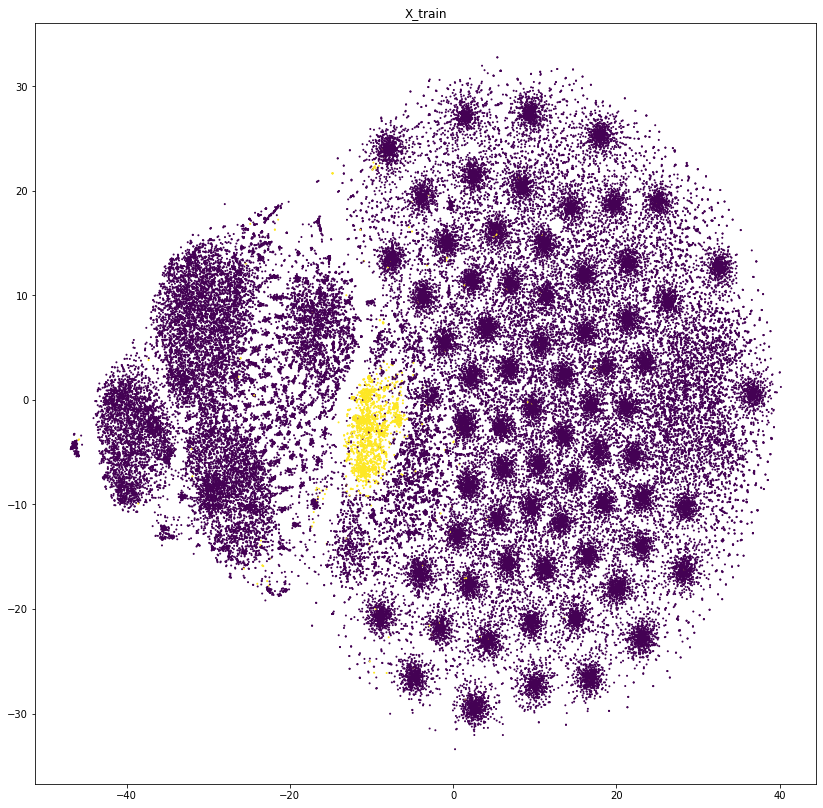

In [8]:
matplotlib.pyplot.figure(figsize=(14, 14))
matplotlib.pyplot.title('X_train')
matplotlib.pyplot.scatter(reduced_dimensionality_X_train[:,0], reduced_dimensionality_X_train[:,1], c=y_train, s=1)
matplotlib.pyplot.show()

...and now, the same with `X_test`.

In [9]:
%%time
reduced_dimensionality_X_test = tsne.fit_transform(
    X=parallel_estimator(
        estimator=pipeline_visualization,
        X=X_test,
        method='fit_transform',
        n_jobs=MAX_WORKERS,
    )
)

CPU times: user 10min 47s, sys: 15.5 s, total: 11min 2s
Wall time: 2min 36s


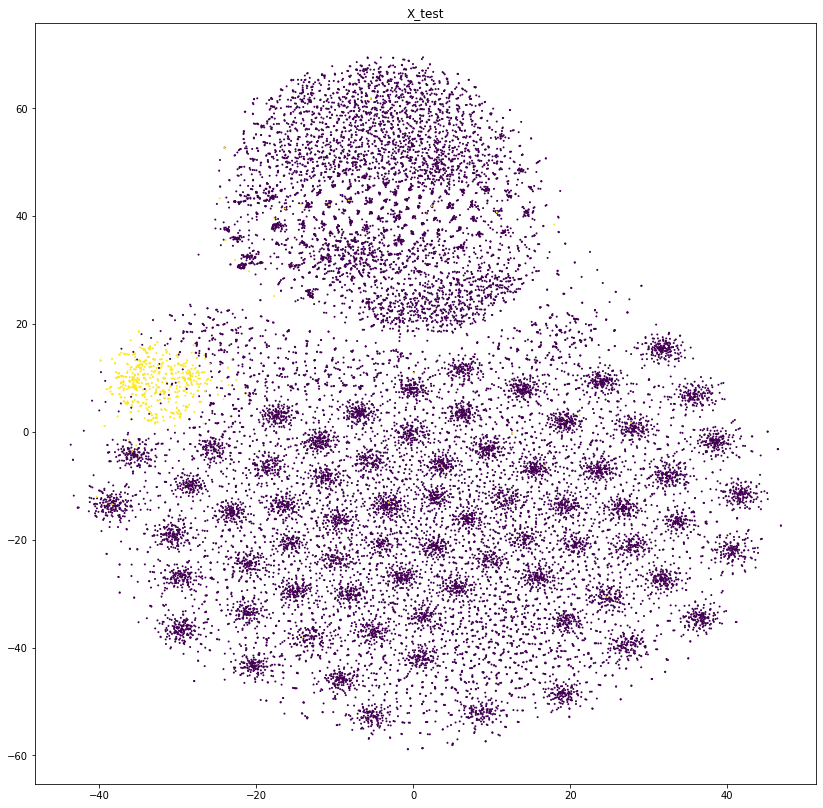

In [10]:
matplotlib.pyplot.figure(figsize=(14, 14))
matplotlib.pyplot.title('X_test')
matplotlib.pyplot.scatter(reduced_dimensionality_X_test[:,0], reduced_dimensionality_X_test[:,1], c=y_test, s=1)
matplotlib.pyplot.show()

---

## Training

Create one or more Scikit-Learn pipelines with the following steps:
1. `TransformerVectorizer`: vectorizes preprocessed text.
2. `RandomForestClassifier`, `LogisticRegressionCV`, `GaussianNB`, or other: classifies text as positive or negative examples of contracts.

In [11]:
pipeline_random_forest: Pipeline = make_pipeline(
    transformer_vectorizer,  # <-- already instantiated; used for the visualization
    MinMaxScaler(feature_range=(-1.0, 1.0)),
    RandomForestClassifier(
        n_estimators=100,
        random_state=0,
        class_weight='balanced',
        n_jobs=MAX_WORKERS,
    )
)

In [12]:
pipeline_logistic_regression: Pipeline = make_pipeline(
    transformer_vectorizer,  # <-- already instantiated; used for the visualization
    MinMaxScaler(feature_range=(-1.0, 1.0)),
    LogisticRegressionCV(
        n_jobs=MAX_WORKERS,
        class_weight='balanced',
        max_iter=200,
    ),
)

In [6]:
pipeline_naive_bayes: Pipeline = make_pipeline(
    transformer_vectorizer,  # <-- already instantiated; used for the visualization
    MinMaxScaler(feature_range=(-1.0, 1.0)),
    GaussianNB(),
)

Finally, fit the pipeline(s) to the training data.

In [14]:
%%time
pipeline_random_forest: Pipeline = pipeline_random_forest.fit(X_train, y_train)

CPU times: user 15min 45s, sys: 807 ms, total: 15min 46s
Wall time: 13min 43s


In [15]:
%%time
pipeline_logistic_regression: Pipeline = pipeline_logistic_regression.fit(X_train, y_train)

CPU times: user 12min 59s, sys: 1.74 s, total: 13min 1s
Wall time: 13min 9s


In [7]:
%%time
pipeline_naive_bayes: Pipeline = pipeline_naive_bayes.fit(X_train, y_train)

CPU times: user 13min 22s, sys: 531 ms, total: 13min 23s
Wall time: 13min 23s


---

## Metrics

For each trained pipeline, evaluate test performance.

RANDOMFORESTCLASSIFIER
              precision    recall  f1-score   support

       False       0.98      1.00      0.99     20652
        True       1.00      0.22      0.35       580

    accuracy                           0.98     21232
   macro avg       0.99      0.61      0.67     21232
weighted avg       0.98      0.98      0.97     21232

CPU times: user 4.56 s, sys: 3.65 s, total: 8.21 s
Wall time: 1min 10s


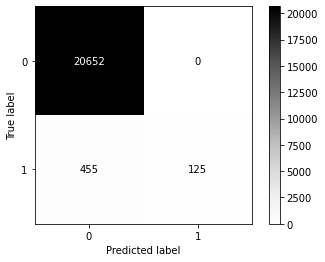

In [17]:
%%time
# noinspection PyProtectedMember
print(pipeline_random_forest._final_estimator.__class__.__name__.upper())

y_pred: ndarray = parallel_estimator(
    estimator=pipeline_random_forest,
    X=X_test,
    method='predict',
    n_jobs=MAX_WORKERS,
)
confusion_matrix_display: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_test,
        y_pred=y_pred,
    )
)

confusion_matrix_display.plot(cmap='Greys')

print(
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
    )
)

LOGISTICREGRESSIONCV
              precision    recall  f1-score   support

       False       1.00      0.98      0.99     20652
        True       0.63      0.94      0.76       580

    accuracy                           0.98     21232
   macro avg       0.82      0.96      0.88     21232
weighted avg       0.99      0.98      0.99     21232

CPU times: user 1.75 s, sys: 704 ms, total: 2.45 s
Wall time: 1min 14s


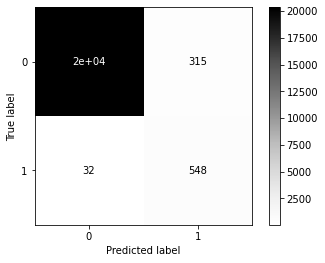

In [18]:
%%time

# noinspection PyProtectedMember
print(pipeline_logistic_regression._final_estimator.__class__.__name__.upper())

y_pred: ndarray = parallel_estimator(
    estimator=pipeline_logistic_regression,
    X=X_test,
    method='predict',
    n_jobs=MAX_WORKERS,
)
confusion_matrix_display: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_test,
        y_pred=y_pred,
    )
)

confusion_matrix_display.plot(cmap='Greys')

print(
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
    )
)

GAUSSIANNB
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20652
        True       0.85      0.91      0.88       580

    accuracy                           0.99     21232
   macro avg       0.93      0.95      0.94     21232
weighted avg       0.99      0.99      0.99     21232

CPU times: user 1.88 s, sys: 568 ms, total: 2.45 s
Wall time: 1min 8s


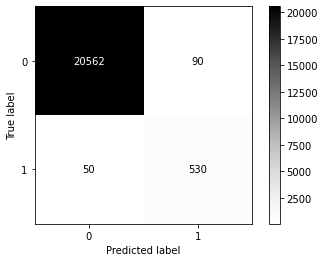

In [8]:
%%time

# noinspection PyProtectedMember
print(pipeline_naive_bayes._final_estimator.__class__.__name__.upper())

y_pred: ndarray = parallel_estimator(
    estimator=pipeline_naive_bayes,
    X=X_test,
    method='predict',
    n_jobs=MAX_WORKERS,
)
confusion_matrix_display: ConfusionMatrixDisplay = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_test,
        y_pred=y_pred,
    )
)

confusion_matrix_display.plot(cmap='Greys')

print(
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
    )
)

---

## Saving the pipeline

Choose the best-performing pipeline and save it using `cloudpickle`.

First, we need the same `Normalizer` as was used to preprocess the original training data.

In [9]:
NORMALIZER: Final[Normalizer] = Normalizer(
    normalizations=(
        (get_ratio_annotations, '__RATIO__'),
        (get_date_annotations, '__DATE__'),
        (get_percent_annotations, '__PERCENT__'),
        (get_amount_annotations, '__AMOUNT__'),
    ),
)

Then, insert at the beginning of the pipeline an instance of `TransformerPreprocessor`. Finally, save the pipeline to a file using `cloudpickle`.

In [30]:
# Insert an instance of TransformerPreprocessor
pipeline_naive_bayes.steps.insert(
    0,
    (
        TransformerPreprocessor.__name__.lower(),
        TransformerPreprocessor(normalizer=NORMALIZER, head_character_n=2000)
    )
)

# now save the pipeline
with open('./output/pipeline_is_contract_classifier.cloudpickle', 'wb') as f:
    cloudpickle.dump(pipeline_naive_bayes, f)

---

## Usage

First, load the pipeline from disk.

In [31]:
with open('./output/pipeline_is_contract_classifier.cloudpickle', 'rb') as f:
    pipeline_is_contract_classifier: Pipeline = cloudpickle.load(f)

Then, pass the combined pipeline as an argument to `ProbabilityPredictorIsContract`'s `pipeline` parameter.

In [32]:
probability_predictor_is_contract: ProbabilityPredictorIsContract = \
    ProbabilityPredictorIsContract(pipeline=pipeline_is_contract_classifier)

probability_predictor_is_contract.is_contract(
    text='...',
    min_probability=0.5,
    return_probability=True,
)

(False, 8.512196146320674e-12)

---

## Alternative: Only Saving the Classifier

This will not save the entire pipeline.

In [ ]:
with open('./output/is_contract_classifier.cloudpickle', 'wb') as f:
    # noinspection PyProtectedMember
    cloudpickle.dump(pipeline_logistic_regression._final_estimator, f)